# Part 1: Preprocessing with Bag-of-Words

## Import libraries and load the files

In [244]:
import numpy as np
import pandas as pd
import string
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics.pairwise as smp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

In [53]:
data_set = pd.read_csv('data/yelp_2k.csv', usecols = ['stars', 'text']).values.tolist()
data_set_pd = pd.read_csv('data/yelp_2k.csv', usecols = ['stars', 'text'])
data_set_orig = pd.read_csv('data/yelp_2k.csv', usecols = ['stars', 'text']).values.tolist()
data_set_orig_pd = pd.read_csv('data/yelp_2k.csv', usecols = ['stars', 'text'])

## Convert the text into bag-of-words representation

### Tokenize the text and convert to lower case

In [3]:
tokenizer = RegexpTokenizer(r'\w+')

In [4]:
for idx in range(len(data_set)):
    data_set[idx][1] = data_set[idx][1].lower()
    data_set[idx][1] = np.array(tokenizer.tokenize(data_set[idx][1]))

### Analyze / repreprocess

In [5]:
all_words = []
for idx in range(len(data_set)):
    for w in data_set[idx][1]:
            all_words.append(w)

In [6]:
len(all_words) # Total words

241841

In [245]:
all_words = FreqDist(all_words)
print(f"Total unique words: {len(all_words)}")

Total unique words 13186


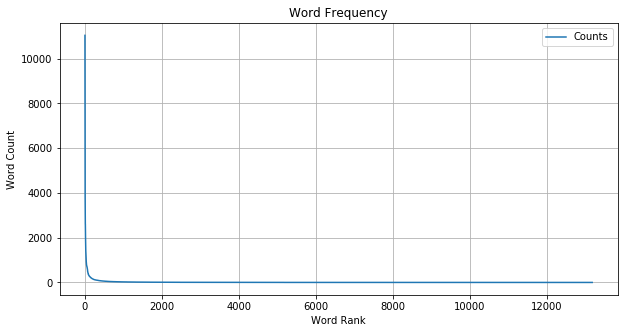

In [246]:
# Graph the whole dataset
y_val = [x[1] for x in all_words.most_common()]
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
plt.grid()

plt.plot(y_val, label = 'Counts')
plt.legend(loc='upper right')
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.title("Word Frequency")
plt.show()

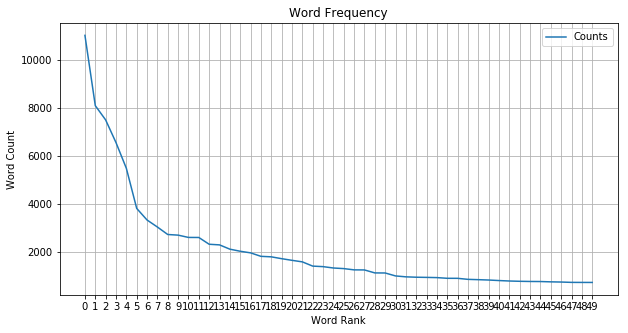

In [247]:
# Graph ranks of only the top 50 most frequently used words

y_val = [x[1] for x in all_words.most_common()[:50]]
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax.set_xticks(np.arange(0, 50, 1))
plt.grid()

plt.plot(y_val, label = 'Counts')
plt.legend(loc='upper right')
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.title("Word Frequency")
plt.show()

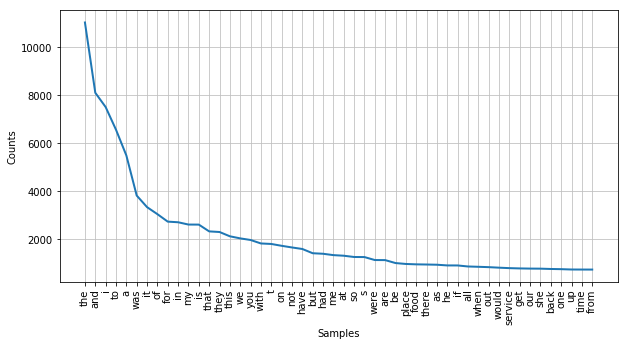

In [248]:
# Graph top 50 most frequently used words but show the words

plt.figure(figsize=(10, 5))
all_words.plot(50,cumulative=False) # Top 50 used words
plt.show()

## Remove Stop Words

In [11]:
# Identify top 16 stop words
all_words.most_common(16)

[('the', 11041),
 ('and', 8107),
 ('i', 7511),
 ('to', 6565),
 ('a', 5491),
 ('was', 3817),
 ('it', 3333),
 ('of', 3040),
 ('for', 2728),
 ('in', 2702),
 ('my', 2606),
 ('is', 2604),
 ('that', 2321),
 ('they', 2295),
 ('this', 2116),
 ('we', 2029)]

In [12]:
# Remove words that appear 1 times
less_common = all_words.hapaxes()
print(f"Less common words {len(less_common)}")

Less common words 5972


In [13]:
# Let's choose a max document frequency theshold for word occurences and a minimum word occurence to cull the less useful words
# We will remove any word that occurs more than 2,000 times
# We will not remove any word based on the minimum occurence

In [14]:
my_stop_words = less_common
for w in all_words.most_common(16):
    my_stop_words.append(w[0])

In [15]:
my_stop_words = my_stop_words + less_common
print(f"Removing {len(my_stop_words)} stop words")

Removing 11976 stop words


In [16]:
# Remove stop words from the dataset
all_words_clean = []

for idx in range(len(data_set)):
    filtered_text = []
    
    for w in data_set[idx][1]:
        if w not in my_stop_words:
            filtered_text.append(w)
            all_words_clean.append(w)
    data_set[idx][1] = filtered_text

In [17]:
len(all_words_clean) # Total words

167563

In [18]:
all_words_clean = FreqDist(all_words_clean)
len(all_words_clean) # Total unique words

7198

In [19]:
all_words_clean.most_common(16)

[('you', 1962),
 ('with', 1817),
 ('t', 1796),
 ('on', 1719),
 ('not', 1650),
 ('have', 1586),
 ('but', 1409),
 ('had', 1387),
 ('me', 1330),
 ('at', 1305),
 ('so', 1252),
 ('s', 1249),
 ('were', 1125),
 ('are', 1122),
 ('be', 999),
 ('place', 961)]

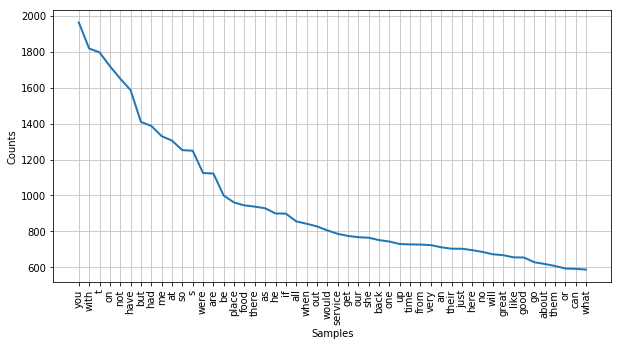

In [249]:
# Graph top 50 most frequently used words but show the words

plt.figure(figsize=(10, 5))
all_words_clean.plot(50,cumulative=False) # Top 50 used words
plt.show()

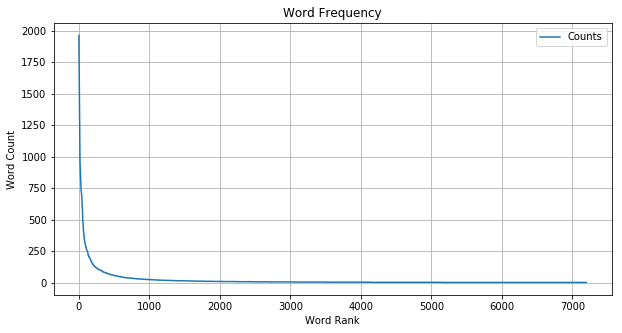

In [250]:
# Graph the clean dataset

y_val = [x[1] for x in all_words_clean.most_common()]
fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
plt.grid()

plt.plot(y_val, label = 'Counts')
plt.legend(loc='upper right')
plt.xlabel("Word Rank")
plt.ylabel("Word Count")
plt.title("Word Frequency")
plt.show()

### Convert all the data into bag-of-words vectors

In [22]:
word_features = list(all_words_clean.keys())

In [23]:
def bagofwords(sentence, features):
    bag = np.zeros(len(features))
    for sw in sentence:
        for i,word in enumerate(features):
            if word == sw: 
                bag[i] += 1
    return np.array(bag)

In [24]:
word_feature_vectors = np.zeros(len(word_features)*2000, dtype = int).reshape(2000, len(word_features))
y = np.zeros(2000)

In [25]:
for idx in tqdm(range(len(data_set))):
    word_feature_vectors[idx] = bagofwords(data_set[idx][1], word_features)

In [26]:
for idx in range(len(data_set)):
    y[idx] = data_set[idx][0]

# Part 2: Text-Retrieval

In [27]:
# In this section, we look at finding similar documents to a query phrase.

# Using nearest neightbor with a cos-distance metric, find 5 reviews matching Horrible customer service.
# Print the original text from the review along with the associated distance score. You can truncate the review to 200 words so we don't get a page of text.
# Looking at all the distance scores, how many documents do you think are good matches to the query?

In [28]:
def reviewToWordIndex(review):
    review_idx = []
    for word in review:
        word_idx = word_features.index(word) if word in word_features else -1
        review_idx.append(word_idx)
    return np.array(review_idx)

In [29]:
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in my_stop_words]

In [30]:
reviews = [i[1] for i in data_set_orig]
x_reviews = np.array([reviewToWordIndex(i[1]) for i in data_set])
y_ratings = np.array([i[0] for i in data_set])

In [31]:
vectorizer = CountVectorizer(stop_words = my_stop_words, analyzer=text_process)
tfidf_matrix = vectorizer.fit_transform(reviews)

In [34]:
nbrs = NearestNeighbors(n_neighbors=10, metric='cosine').fit(tfidf_matrix)

In [218]:
def get_closest(search_term):
    distances, indices = nbrs.kneighbors(vectorizer.transform([search_term]), 5)
    distances = distances.flatten()
    indices = indices.flatten()
    reviews = data_set_pd.iloc[indices]['text']
    return distances, np.array(reviews)

In [241]:
nearest_reviews = get_closest('Horrible customer service')

In [242]:
pd.DataFrame({'distance':nearest_reviews[0], 'name':nearest_reviews[1]})

,distance,name
0,0.571155,Rogers ...\n\n1) is over priced\n2) have horri...
1,0.617640,Went to Marca today to get a haircut and was g...
2,0.668867,"Horrible service, horrible customer service, a..."
3,0.672673,Not $19.95. Unmarked cars and no uniforms. Bad...
4,0.673401,Horrible customer service! Been with them ove...


In [243]:
nearest_reviews[1]

array(['Rogers ...\n\n1) is over priced\n2) have horrible customer service\n3) faulty and incorrect billing\n4) poor customer service\n5) not enough options\n6) never arrive for an appointment',
       'Went to Marca today to get a haircut and was given a great service both by front desk - customer service and by Georgia, girl who did my hair. I guess I got lucky with her as she has years of experience doing this job. She has excellent customer service skills and takes excellent care of her customers.',
       'Horrible service, horrible customer service, and horrible quality of service!  Do not waste your time or money using this company for your pool needs.  Dan (602)363-8267 broke my pool filtration system and left it in a nonworking condition.  He will not repair the issue he caused, and told me to go somewhere else.  \n\nSave yourself the hassle, there are plenty of other quality pool companies out there.  \n\nTake care!',
       'Not $19.95. Unmarked cars and no uniforms. Bad cus

# Part 3: Classification with Logistic Regression

In [829]:
X_train, X_test, y_train, y_test = train_test_split(word_feature_vectors, y, test_size=0.1, random_state=0)

In [830]:
logreg = LogisticRegression()

In [831]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [832]:
y_pred=logreg.predict(X_test)

In [835]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.91
Precision: 0.936842105263
Recall: 0.881188118812
